# Fitting A Linear Model to Data with Errors in X and Y

Probably one of the most common things we do is fit one observable against another. This is typically done with the method of least-squares. If you assume the uncertainty in your data is Gaussian, then you get the best-fit by minimizing $\chi^2$:
$$ \chi ^2 = \sum \frac{\left(y_i - m(x_i)\right)^2}{\sigma^2_i} $$
where your data points $(x_i,y_i)$ are fit with a model $m(x_i)$ and have errors $\sigma_i$. The problem is, what if there are errors in both $x$ and $y$?

To explore this, we'll create some fake data (just so we know exactly what's going on and what the truth is) and plot it out. You can change the number of points, errors, and slopes/intercet if you like.

Text(0, 0.5, 'Y')

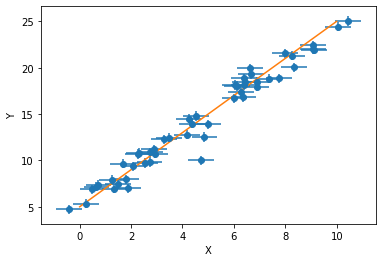

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 50
sig_x = 0.5
sig_y = 0.5
a_true = 5.0
b_true = 2.0

x_true = np.random.uniform(0,10,size=N)
y_true = a_true + x_true*b_true
x_obs = x_true + np.random.normal(0, sig_x, size=N)
y_obs = y_true + np.random.normal(0, sig_y, size=N)

fig,ax = plt.subplots(1)
ax.errorbar(x_obs, y_obs, xerr=sig_x, yerr=sig_y, fmt='o')
xx = np.array([0,10])
yy = a_true + xx*b_true
ax.plot(xx, yy, '-')
ax.set_xlabel('X')
ax.set_ylabel('Y')

Looks reasonable, I hope. We want to find the best-fit line to the data. It should be close to the orange line (the truth), but not equal, since we introduced noise. First, we could fit this with ``scipy.optimize.curve_fit`` as in a previous notebook. It needs an error (``sigma``), but that's usually the error in $y$. How do we incorporate the error in $x$?. Well, one way to think about it is we are minimizing the residuals (numerator of $\chi^2$), call them $\Delta_i$:
$$ \Delta_i = y_i - (a + b x_i)$$
so the total uncertainty is:
$$ \sigma^2_i = \left(\frac{\partial \Delta_i}{\partial x_i}\right)^2 \sigma^2_{x,i} + \left(\frac{\partial \Delta_i}{\partial y_i}\right)^2 \sigma^2_{y,i} = b^2\sigma^2_{x,i} + \sigma^2_{y,i}$$
So we just need to add the error in y to the error in x, scaled by the slope, in quadrature. But... we don't know the slope until we solve the problem! Normally, you would make an initial guess, compute the errors, fit for the line, update the slope, compute the errors again, fit for a better slope, and repeat this process until the slope converges to a fixed value. So save on space, let's just cheat and use the true slope to compute the errors.

[5.37330111 1.89159469]
[[ 0.08629013 -0.01343256]
 [-0.01343256  0.00285801]]


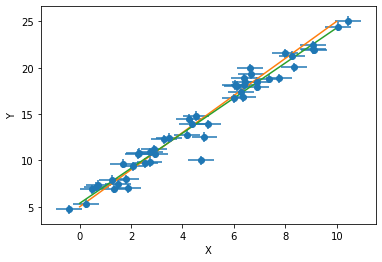

In [2]:
from scipy.optimize import curve_fit
def mod(x, a, b):
    return a + x*b
sig_y = np.ones(N)*sig_y   # curve_fit needs arrays of errors
sig_x = np.ones(N)*sig_x
sigma_total = np.sqrt(sig_y**2 + b_true**2*sig_x**2)
pars,cov = curve_fit(mod, x_obs, y_obs, [0, 1], sigma=sigma_total)
print(pars)
print(cov)
ax.plot(xx, xx*pars[1]+pars[0])
fig


The green line (our fit to the data) should be pretty close to the orange line. You could re-run the notebook a few times to see the result change again and again (since the data would be random each time). This is a method called Monte Carlo (MC) and you can use it to make sure your method is working. Let's do that. We'll re-create the data many times (you can choose how long you want to wait). Each time, we compute the slope and intercept, then save these values in a couple of lists. Finally, make histograms of the values we got and compare to the truth.

Text(0.5, 0, 'intercept')

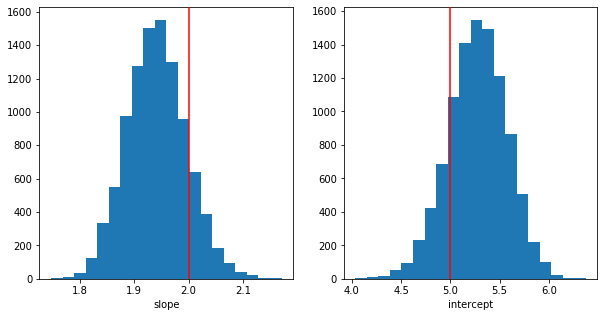

In [3]:
slopes = []
intercepts = []
for i in range(10000):
    x_obs = x_true + np.random.normal(0, sig_x, size=N)
    y_obs = y_true + np.random.normal(0, sig_y, size=N)
    sig_total = y_obs*0 + np.sqrt(sig_x**2*b_true**2 + sig_y**2)
    pars,cov = curve_fit(mod, x_obs, y_obs, [0,1], sigma=sig_total)
    slopes.append(pars[1])
    intercepts.append(pars[0])
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(slopes, bins=20)
axes[0].axvline(b_true, color='red', zorder=10)
axes[0].set_xlabel('slope')
axes[1].hist(intercepts, bins=20)
axes[1].axvline(a_true, color='red', zorder=10)
axes[1].set_xlabel('intercept')

You should see a couple of histograms and red lines that represent the true values. Depending on what you chose for your uncertainties, the red lines may not line up with the peaks of the distributions. In fact, the larger you make the $x$ errors, the more they won't agree. Now, this isn't just due to a random draw and noisy data. This is happening *on average* over a large number of trials. The conclusion:  least-squares is a biased estimator of a linear model when errors are present in the $x$ values (also called the predictor variable).

The reason is a subtle one which we'll get to. But you might be thinking that it has something to do with keeping the errors $\sigma_i$ fixed, when they really should vary as the slope varies. We can test that, but least-squares won't allow this. Instead, we can use the MCMC techniques we saw earlier. First up, let's do the problem with ``emcee``.

In [4]:
from scipy.stats import norm
def lnprior(p):
    a,b = p
    return 0

def lnlike(p, x, y, dx, dy):
    a,b = p
    model = mod(x, a, b)
    sig_tot = np.sqrt(dx**2*b**2 + dy**2)
    return sum(norm.logpdf(y, loc=model, scale=sig_tot))

def lnprob(p, x, y, dx, dy):
    a,b = p
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -inf
    return lp + lnlike(p, x, y, dx, dy)

Nwalker,Ndim = 10,2
ptrue = np.array([a_true,b_true])
# add a random vector 0.1 times the true vector to the true vector
p0 = [ptrue + 0.1*np.random.randn(Ndim)*ptrue for i in range(Nwalker)]

Note that the priors are completely uninformative (uniform over all values). The likelihood is computed in the usual way with the normal distribution and we comptue the total error based on the current slope, which is updated at each iteration, so the errors will change as the walkers make their way through parameters space. You should think about what this might mean as the slope becomes small or large. Let's run a bunch of walkers and see what we get.

In [5]:
import emcee
sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(x_obs, y_obs, sig_x, sig_y))
pos,prob,state = sampler.run_mcmc(p0, 500)

Now plot out the samples to see how long it takes to get a convergence.

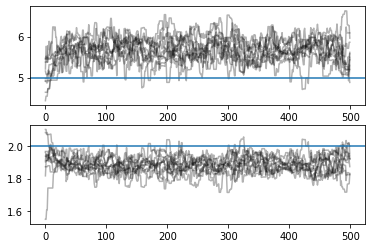

In [6]:
fig,ax = plt.subplots(2,1)
res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3) for i in range(2)]
res = [ax[i].axhline(ptrue[i]) for i in range(2)]

Looks like 100 iterations should do it. Let's reset and run for longer and print out the results.

In [7]:
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, 1000)
print(np.mean(sampler.flatchain, axis=0))
print(np.std(sampler.flatchain, axis=0))

[5.6807195  1.88752001]
[0.28765409 0.05319691]


Okay, slope and intercept are "close". But do we have the same problem we did before? If we run this a bunch of times, will the result still be biased? Let's check. I'm only going to run this for 100 iterations, just to get an idea. MCMC samplers take much longer to run than simple least-squares. We'll print out the index as we go so you can judge if it will take too long on your computer and if you might want to reduce the number of loops.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Text(0.5, 0, 'intercept')

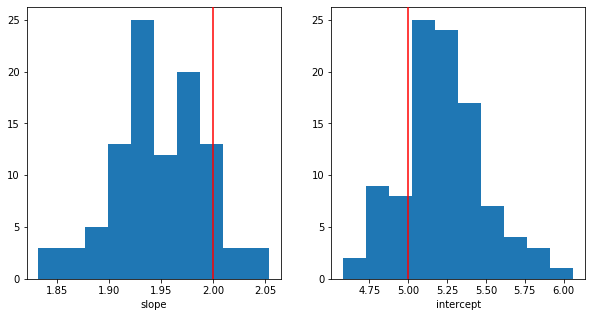

In [8]:
slopes = []
intercepts = []
for i in range(100):
    x_obs = x_true + np.random.normal(0, sig_x, size=N)
    y_obs = y_true + np.random.normal(0, sig_y, size=N)
    sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(x_obs, y_obs, sig_x, sig_y))
    pos,prob,state = sampler.run_mcmc(pos, 100)
    sampler.reset()
    pos,prob,state = sampler.run_mcmc(pos, 500)
    mns = np.mean(sampler.flatchain, axis=0)
    slopes.append(mns[1])
    intercepts.append(mns[0])
    print(i, end=' ')
    
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(slopes, bins=10)
axes[0].axvline(b_true, color='red', zorder=10)
axes[0].set_xlabel('slope')
axes[1].hist(intercepts, bins=10)
axes[1].axvline(a_true, color='red', zorder=10)
axes[1].set_xlabel('intercept')

Hmmmm. Looks like the problem is still there. So what's the reason for this? Well, it has to do with the way that we incorporated the $\sigma_x$, obviously. This was done by what's called *marginalizing*. Let's look a bit more closely at what it means to have observed our data. We know (since we made the fake data ourselves) that both $x$ and $y$ had noise added to them that was Gaussian (normally distributed). So, using $N$ to represent normal distributions, the likelihoods for our observed $x$ and $y$ values are:
$$ P\left(x_i\left| x_i^T,\sigma_{x,i}\right.\right) = N(x_i-x_i^T, \sigma_{x,i})$$
$$ P\left(y_i\left| y_i^T,\sigma_{y,i}\right.\right) = N(y_i-y_i^T, \sigma_{y,i})$$
In other words, the $x$ data is drawn from a normal distribution whose mean (center) is the true value $x^T_i$, and whose width is the uncertainty $\sigma_{x,i}$. Likewise for $y_i$, except the true value of $y_i$ is given by our model, so:
$$ P\left(y_i\left| y_i^T,\sigma_{y,i}\right.\right) = N(y_i - a - b x_i^T, \sigma_{y,i})$$
and together, these give us a joint log-likelihood for the entire data set $\vec{D}$:

$$\log P\left(\vec{D}\left|x_i^T,a,b\right.\right) = \sum_i \log N\left(x_i-x_i^T, \sigma_{x,i}\right)
  + \sum_i \log N\left(y_i - a - b x_i^T, \sigma_{y,i}\right)$$
but we've got all these $x_i^T$ values on the right-hand side. In real life, we don't know what these are, so we are forced to consider them as unknown parameters. It would be really nice if we could get rid of them. Well, turns out you can do that. If you integrate the probability over all possible values of $x_i^T$, weighted by their priors:
$$\log P\left(\vec{D}\left|a,b\right.\right) = \sum_i \int \log P\left(\vec{D}\left|x_i^T,a,b\right.\right)
P\left(x_i^T\right) dx_i^T$$
If we assume: 1) uniform priors $P(x_i^T) \propto 1$, that all $x_i^T$ are independent, and integrate from $-\infty$ to $+\infty$, we get the nice result:
$$ P\left(\vec{D}\left|a,b\right.\right) = \sum_i \log N\left(y_i - a - b x_i, \sqrt{\sigma^2_{y,i}+b^2\sigma^2_{x,i}}\right) = - \frac{1}{2}\chi^2$$
and the right-hand side is only in terms of observables and our two parameters of interest. We have marginalized over all the $x_i^T$, so they no longer appear in the likelihood (and in fact have been replaced with the observed $x_i$). And this is just least-squares with the same error we used above.

The *real* problem is we assumed uniform priors on $x_i^T$ and integrated from $-\infty$ to $+\infty$. That is not anywhere close to how we generated $x^T_i$. In the very first cell, I drew ``x_true`` from a uniform distribution between 0 and 10. In reality, no true value of a measurement you make will ever have equal probability over all values from $-\infty$ to $+\infty$. This is why you have to be careful with your priors!

Okay, so we have to fix $P(x_i^T)$. Unfortunately, just about anything you do to make the prior realistic will make it non-integrable. Even just having a uniform prior from 0 to 10 ruins things (there is an analytic solution to the integral of a Gaussian function over infinite limits, but not for finite limits). So to do this "right" we'll have to keep all those $x^T_i$ as free parameters instead of marginalizing. This is going to be a problem for ``emcee``, since the number of walkers generally has to increase geometrically with the number of parameters. Luckily, STAN doesn't have this limitation. So we'll try things out with ``pytstan``. As annoying as STAN is to debug, writing the model is nice and simple:

In [9]:
import pystan
model_str = '''
data {
   int <lower=1> N;   // number of points
   vector[N] x;       // observed x
   vector[N] y;       // observed y
   vector[N] dx;      // error in x
   vector[N] dy;      // error in y
}

parameters {
   real <lower=-10, upper=10> a;        // intercept
   real <lower=-10, upper=10> b;        // slope
   vector<lower=0, upper=10>[N] xtrue;  // true values of x
}

model {
   x ~ normal(xtrue, dx);
   y ~ normal(a + b*xtrue, dy);
}'''
sampler2 = pystan.StanModel(model_code=model_str, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1cf73ee150596a961eccc1ae272d2b5b NOW.


Note that by putting limits (0,10) on ``xtrue``, I've specified a uniform prior, exactly as the true values were drawn. The other parameters also have uniform priors associated with them. Now we prepare the data and run a test sample, and check to see if we have convergence (``rhat`` close to 1.0).

In [10]:
idata = dict(N=len(x_obs), x=x_obs, y=y_obs, dx=sig_x, dy=sig_y)
output = sampler2.sampling(data=idata, chains=4, iter=1000, warmup=500)
print(output)

Inference for Stan model: anon_model_1cf73ee150596a961eccc1ae272d2b5b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           4.87    0.01   0.29   4.31   4.69   4.88   5.07   5.42    719    1.0
b           2.05  1.9e-3   0.05   1.94   2.01   2.05   2.08   2.15    801    1.0
xtrue[1]    0.11  1.9e-3    0.1 3.5e-3   0.04   0.09   0.16   0.37   2534    1.0
xtrue[2]    3.14  4.3e-3   0.23    2.7   2.99   3.14    3.3   3.59   2798    1.0
xtrue[3]    1.95  5.1e-3   0.24   1.47    1.8   1.96   2.11   2.41   2127    1.0
xtrue[4]    5.92  4.3e-3   0.23   5.47   5.76   5.91   6.07   6.36   2843    1.0
xtrue[5]    0.98  5.3e-3   0.24    0.5   0.82   0.98   1.14   1.44   2065    1.0
xtrue[6]     2.2  4.7e-3   0.24   1.73   2.05    2.2   2.36   2.63   2521    1.0
xtrue[7]    6.72  4.2e-3   0.23    6.3   6.56   6.71   6.88   7.17   3005    1.0
xtr

Note that we now have N+2 parameters being reported. I kept the number of iterations lower than I would normally and the values of ``Rhat`` and standard errors in the parameters look reasonable. If not, increase ``iter``. But even though STAN lets you have large numbers of parameters, the more you have, the slower the sampler will be. We'll do the same thing we did above and re-fit random data sets many times. This will take a while...  grab a coffee or tea. Catch up on facebook. But for this final example, we want enough samples to be confident we've "fixed" the problem.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 29

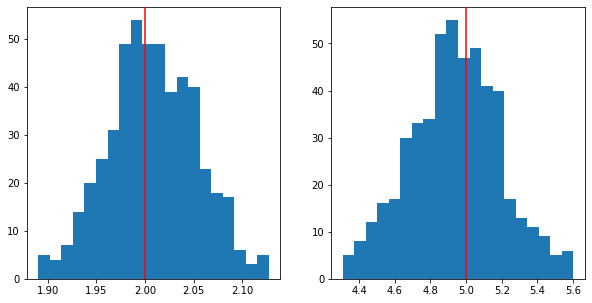

In [11]:
slopes = []
intercepts = []
for i in range(500):
    x_obs = x_true + np.random.normal(0, sig_x, size=N)
    y_obs = y_true + np.random.normal(0, sig_y, size=N)
    idata = dict(N=len(x_obs), x=x_obs, y=y_obs, dx=sig_x, dy=sig_y)
    output = sampler2.sampling(data=idata, chains=4, iter=1000, warmup=500)
    samples = output.extract(permuted=True)
    slopes.append(np.mean(samples['b']))
    intercepts.append(np.mean(samples['a']))
    print(i, end=' ')
    
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(slopes, bins=20)
axes[0].axvline(b_true, color='red', zorder=10)
axes[1].hist(intercepts, bins=20)
axes[1].axvline(a_true, color='red', zorder=10)

What you should now see is that the histograms and true values line up. Maybe not perfectly, but certainly better than they did with least-squares and running ``emcee`` with marginalized $x_i^T$. The takeaway from all this is that biases can creep in not just from data, but also from the numerical methods you use to analyze that data. It's always good to validate your methods with fake data/simulations.